##### imports 

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 

##### data

In [3]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points

##### functions 

In [4]:
# Gompertzian population model
def system_ode_gompertzian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    log_arg = kmax/(Spop + Rpop + epsilon) # stop division by 0

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertzian cost function
def cost_func_gompertzian(params, days, data):
    initial_populations = params[3:] # to let the starting point float
    #initial_populations = [params[3], data[0]-params[3]] # fix starting total to data[0]
    tspan = [days[0], days[-1]]
    
    pred_data = solve_ivp(system_ode_gompertzian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum(sum_pops-data)**2
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error


##### Fitting Gompertzian with differential evolution

In [6]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    max_value = max(data[0], data[-1]) # because sometimes data[0] is not the largest
    
    print("Working on patient:", id, " Number of data points:", len(days)) 
    bounds = [(1e-3, 2e-2), (1.1*max_value, 2*max_value), (1e-1, 100),(0.95*data[0], data[0]-1e-3),(1e-3,0.5*data[0])] 
    #bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]

    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_gompertzian, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result.x.tolist() + [opt_result.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5


C:\Users\lstocker\AppData\Local\Temp\ipykernel_21792\624213342.py:32: RuntimeWarning: overflow encountered in scalar power
  sumsq_error = np.sum(sum_pops-data)**2


Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


In [ ]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,mse
A1002,0.001976,16914.534543,37.945452,13687.147023,3.231174e-27
A1004,0.002226,7208.888460,28.190502,5774.245600,0.000000e+00
A1006,0.001400,22994.063689,87.527200,17658.481081,0.000000e+00
A1007,0.003066,21079.226497,81.618998,11650.369053,0.000000e+00
A1008,0.002046,16884.697139,52.567360,11843.936067,0.000000e+00
A1009,0.001493,23713.944608,69.375311,14086.818750,0.000000e+00
A1011,0.004136,5078.761736,58.735102,3876.749858,0.000000e+00
A1012,0.001756,30645.466568,65.026480,14313.477284,8.271806e-26
A1013,0.001232,25371.789859,51.018026,15518.587806,0.000000e+00
A1014,0.001064,398.997762,77.466344,266.849713,0.000000e+00


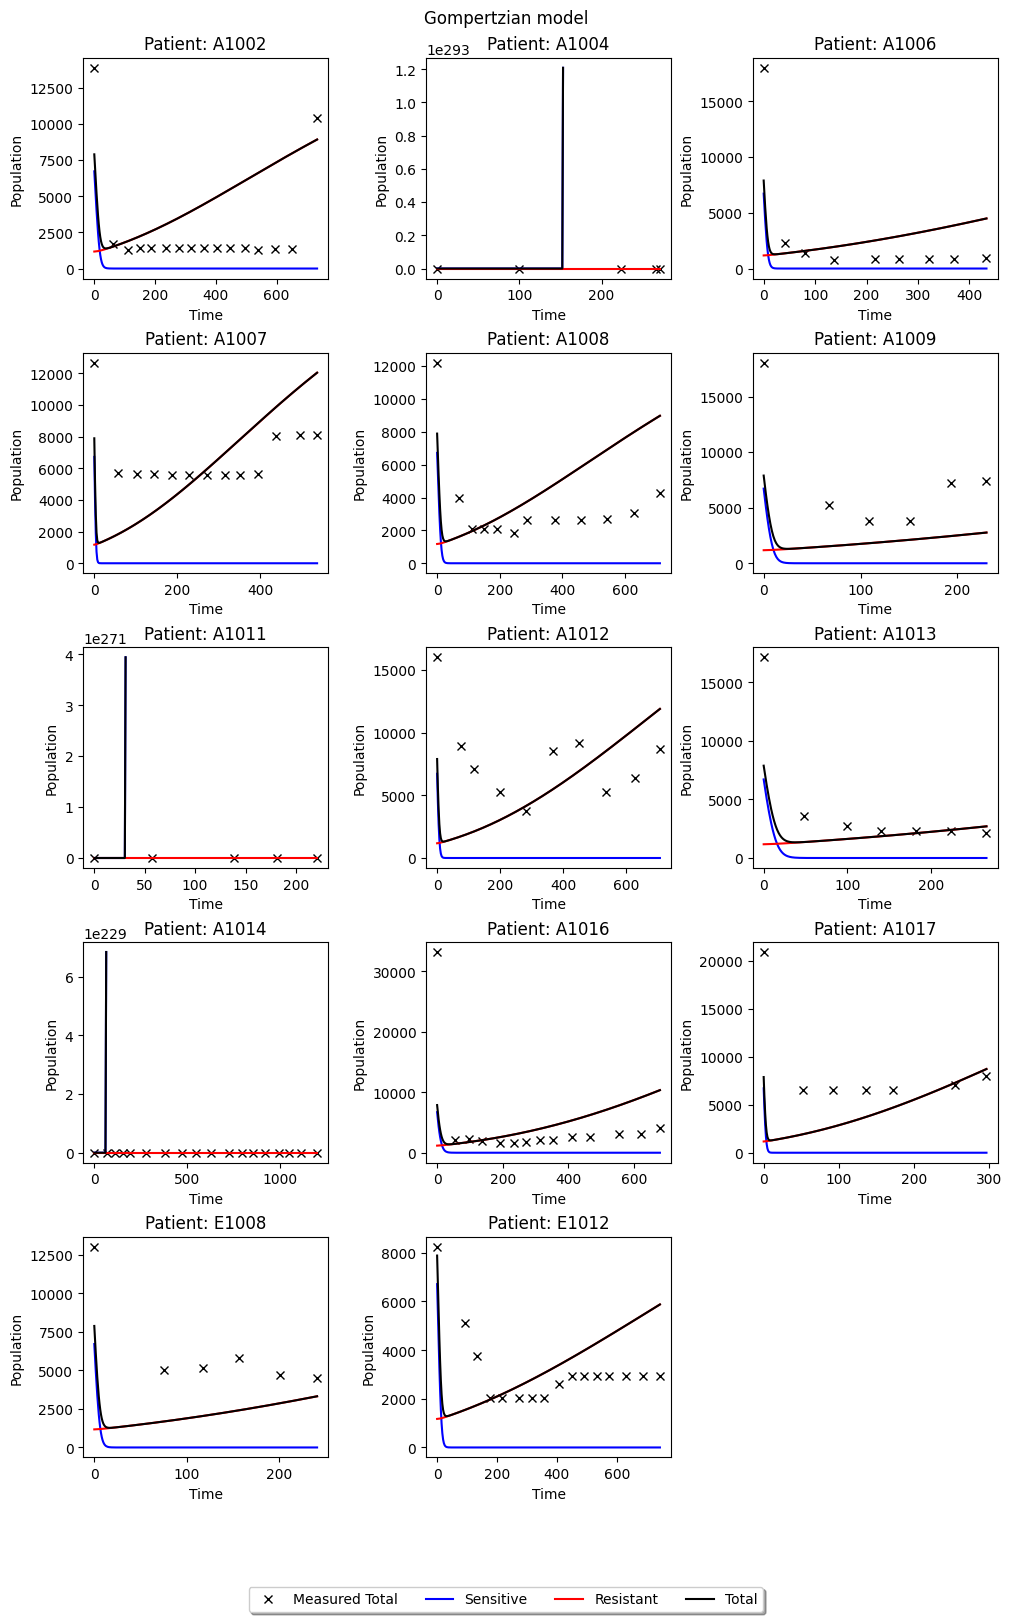

In [ ]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations_log = [optimal_params[3], data[0]-optimal_params[3]]

    pred_data = solve_ivp(system_ode_gompertzian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive') # plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant') 
    ax.plot(tspan, sum_pops, 'k-', label='Total')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

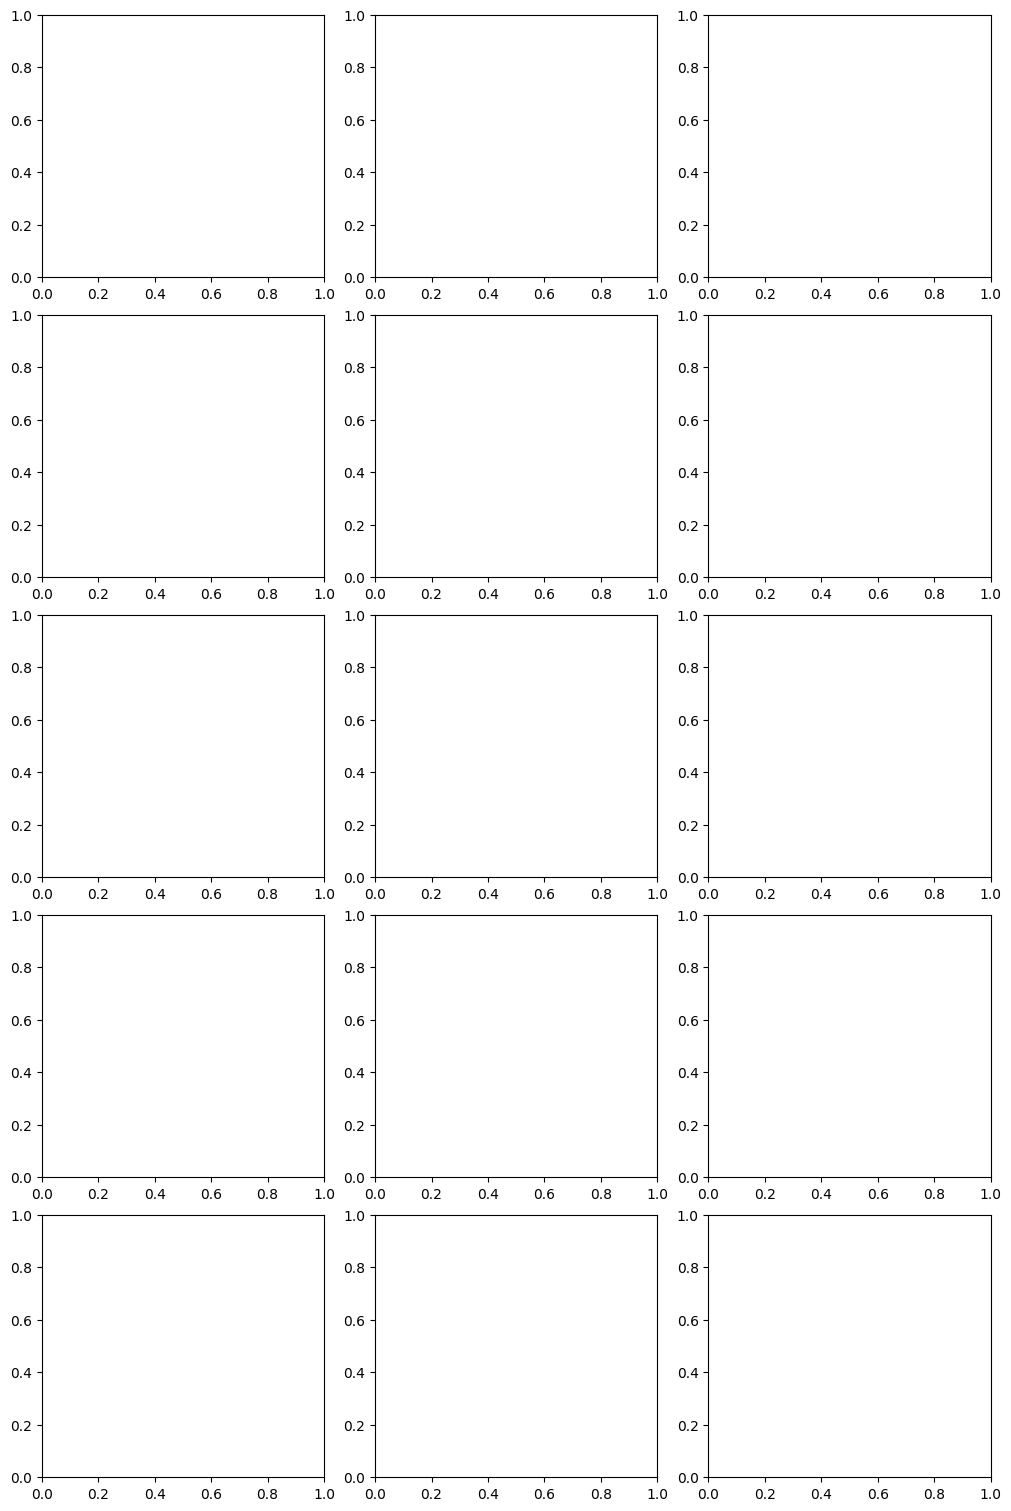

In [ ]:
  
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertzian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [ ]:

df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse


KeyError: 'A1002'

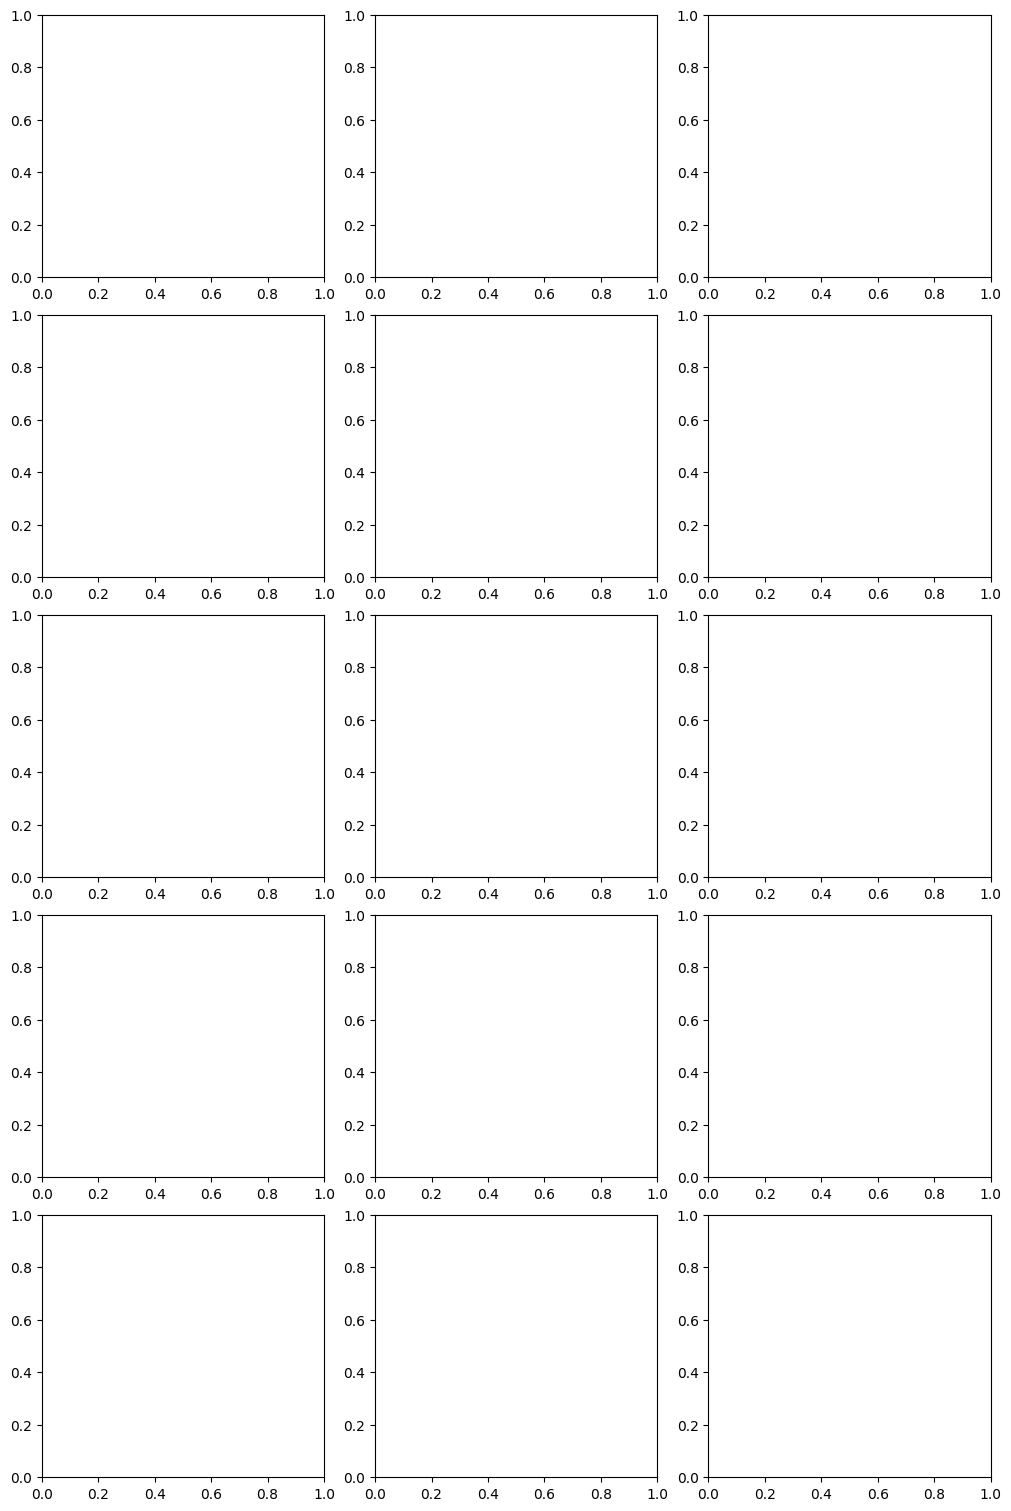

In [ ]:
  # with bigger range
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [ ]:
df_gomp2 = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp2

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.001000,20159.829572,10.000000,5679.723459,554.746427,0.251270
A1004,0.001745,11965.268663,9.986840,5616.999851,224.495377,0.006672
A1006,0.001064,35970.948158,10.000000,7515.979421,284.905704,0.155434
A1007,0.001187,25322.533357,9.996468,6997.751882,3417.299988,0.013622
A1008,0.001000,24378.176081,10.000000,7475.297310,1026.250853,0.039616
A1009,0.004306,35905.116032,5.333771,16452.880972,1359.429701,0.010707
A1011,0.001454,7822.127992,9.994410,3252.885362,38.553750,0.012561
A1012,0.001000,30413.911069,10.000000,11248.980910,3132.537704,0.057272
A1013,0.001379,34257.570246,10.000000,10150.019882,1137.160450,0.069093
A1014,0.001000,442.376602,8.168926,128.286474,5.030391,0.117521


##### Gompertzian DE with 1/2 dose 

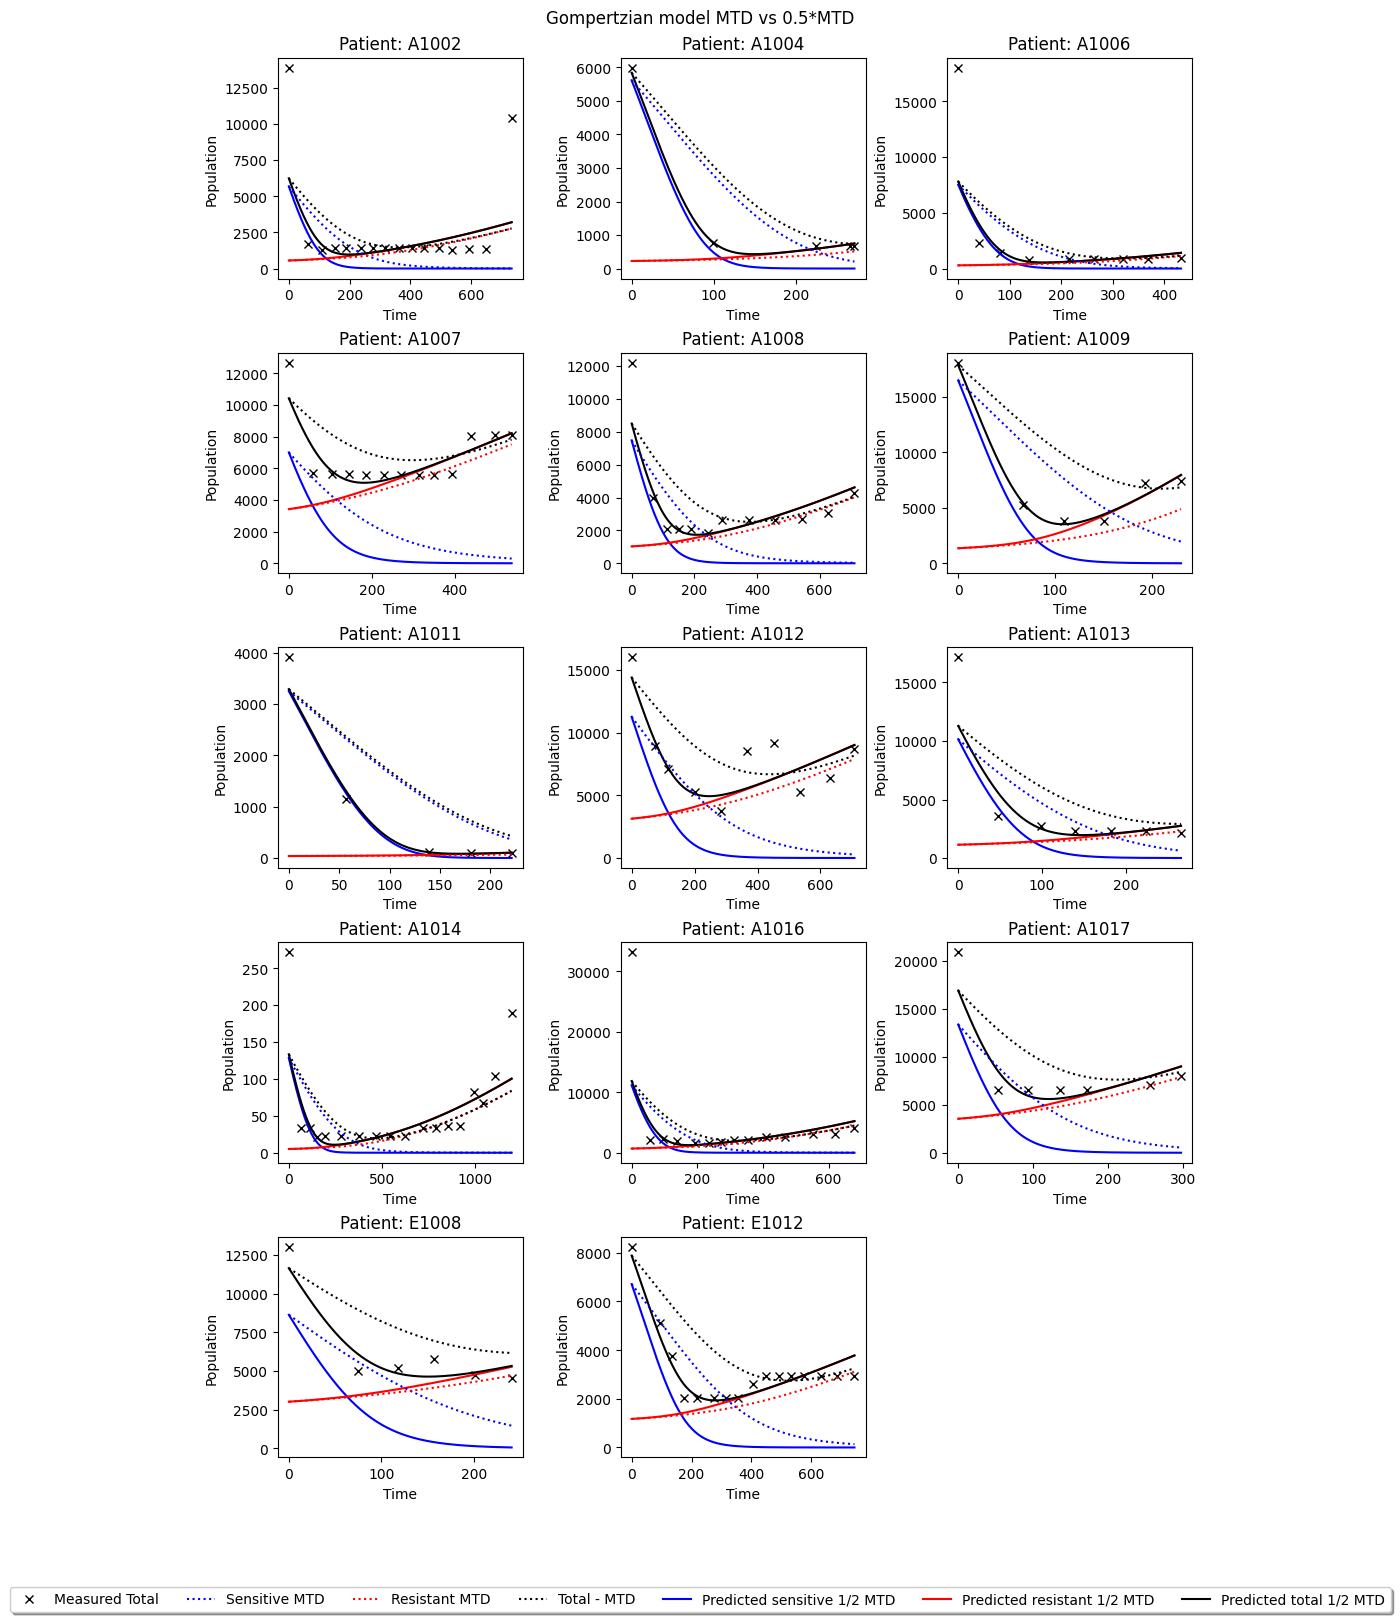

In [ ]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_half, dense_output=True, max_step = 1e-2,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    #plot data
    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive MTD') # plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant MTD') 
    ax.plot(tspan, sum_pops, 'k-', label='Total MTD')

    # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', linestyle=':',label='Sensitive MTD'),
                   Line2D([0], [0], color='r',linestyle=':', label='Resistant MTD'),
                   Line2D([0], [0], color='k', linestyle=':',label='Total - MTD'),

                   Line2D([0], [0], color='b',  label='Predicted sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r',  label='Predicted resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', label='Predicted total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model MTD vs 0.5*MTD')  
plt.show()

##### Extended predictions 1/2 MTD vs MTD

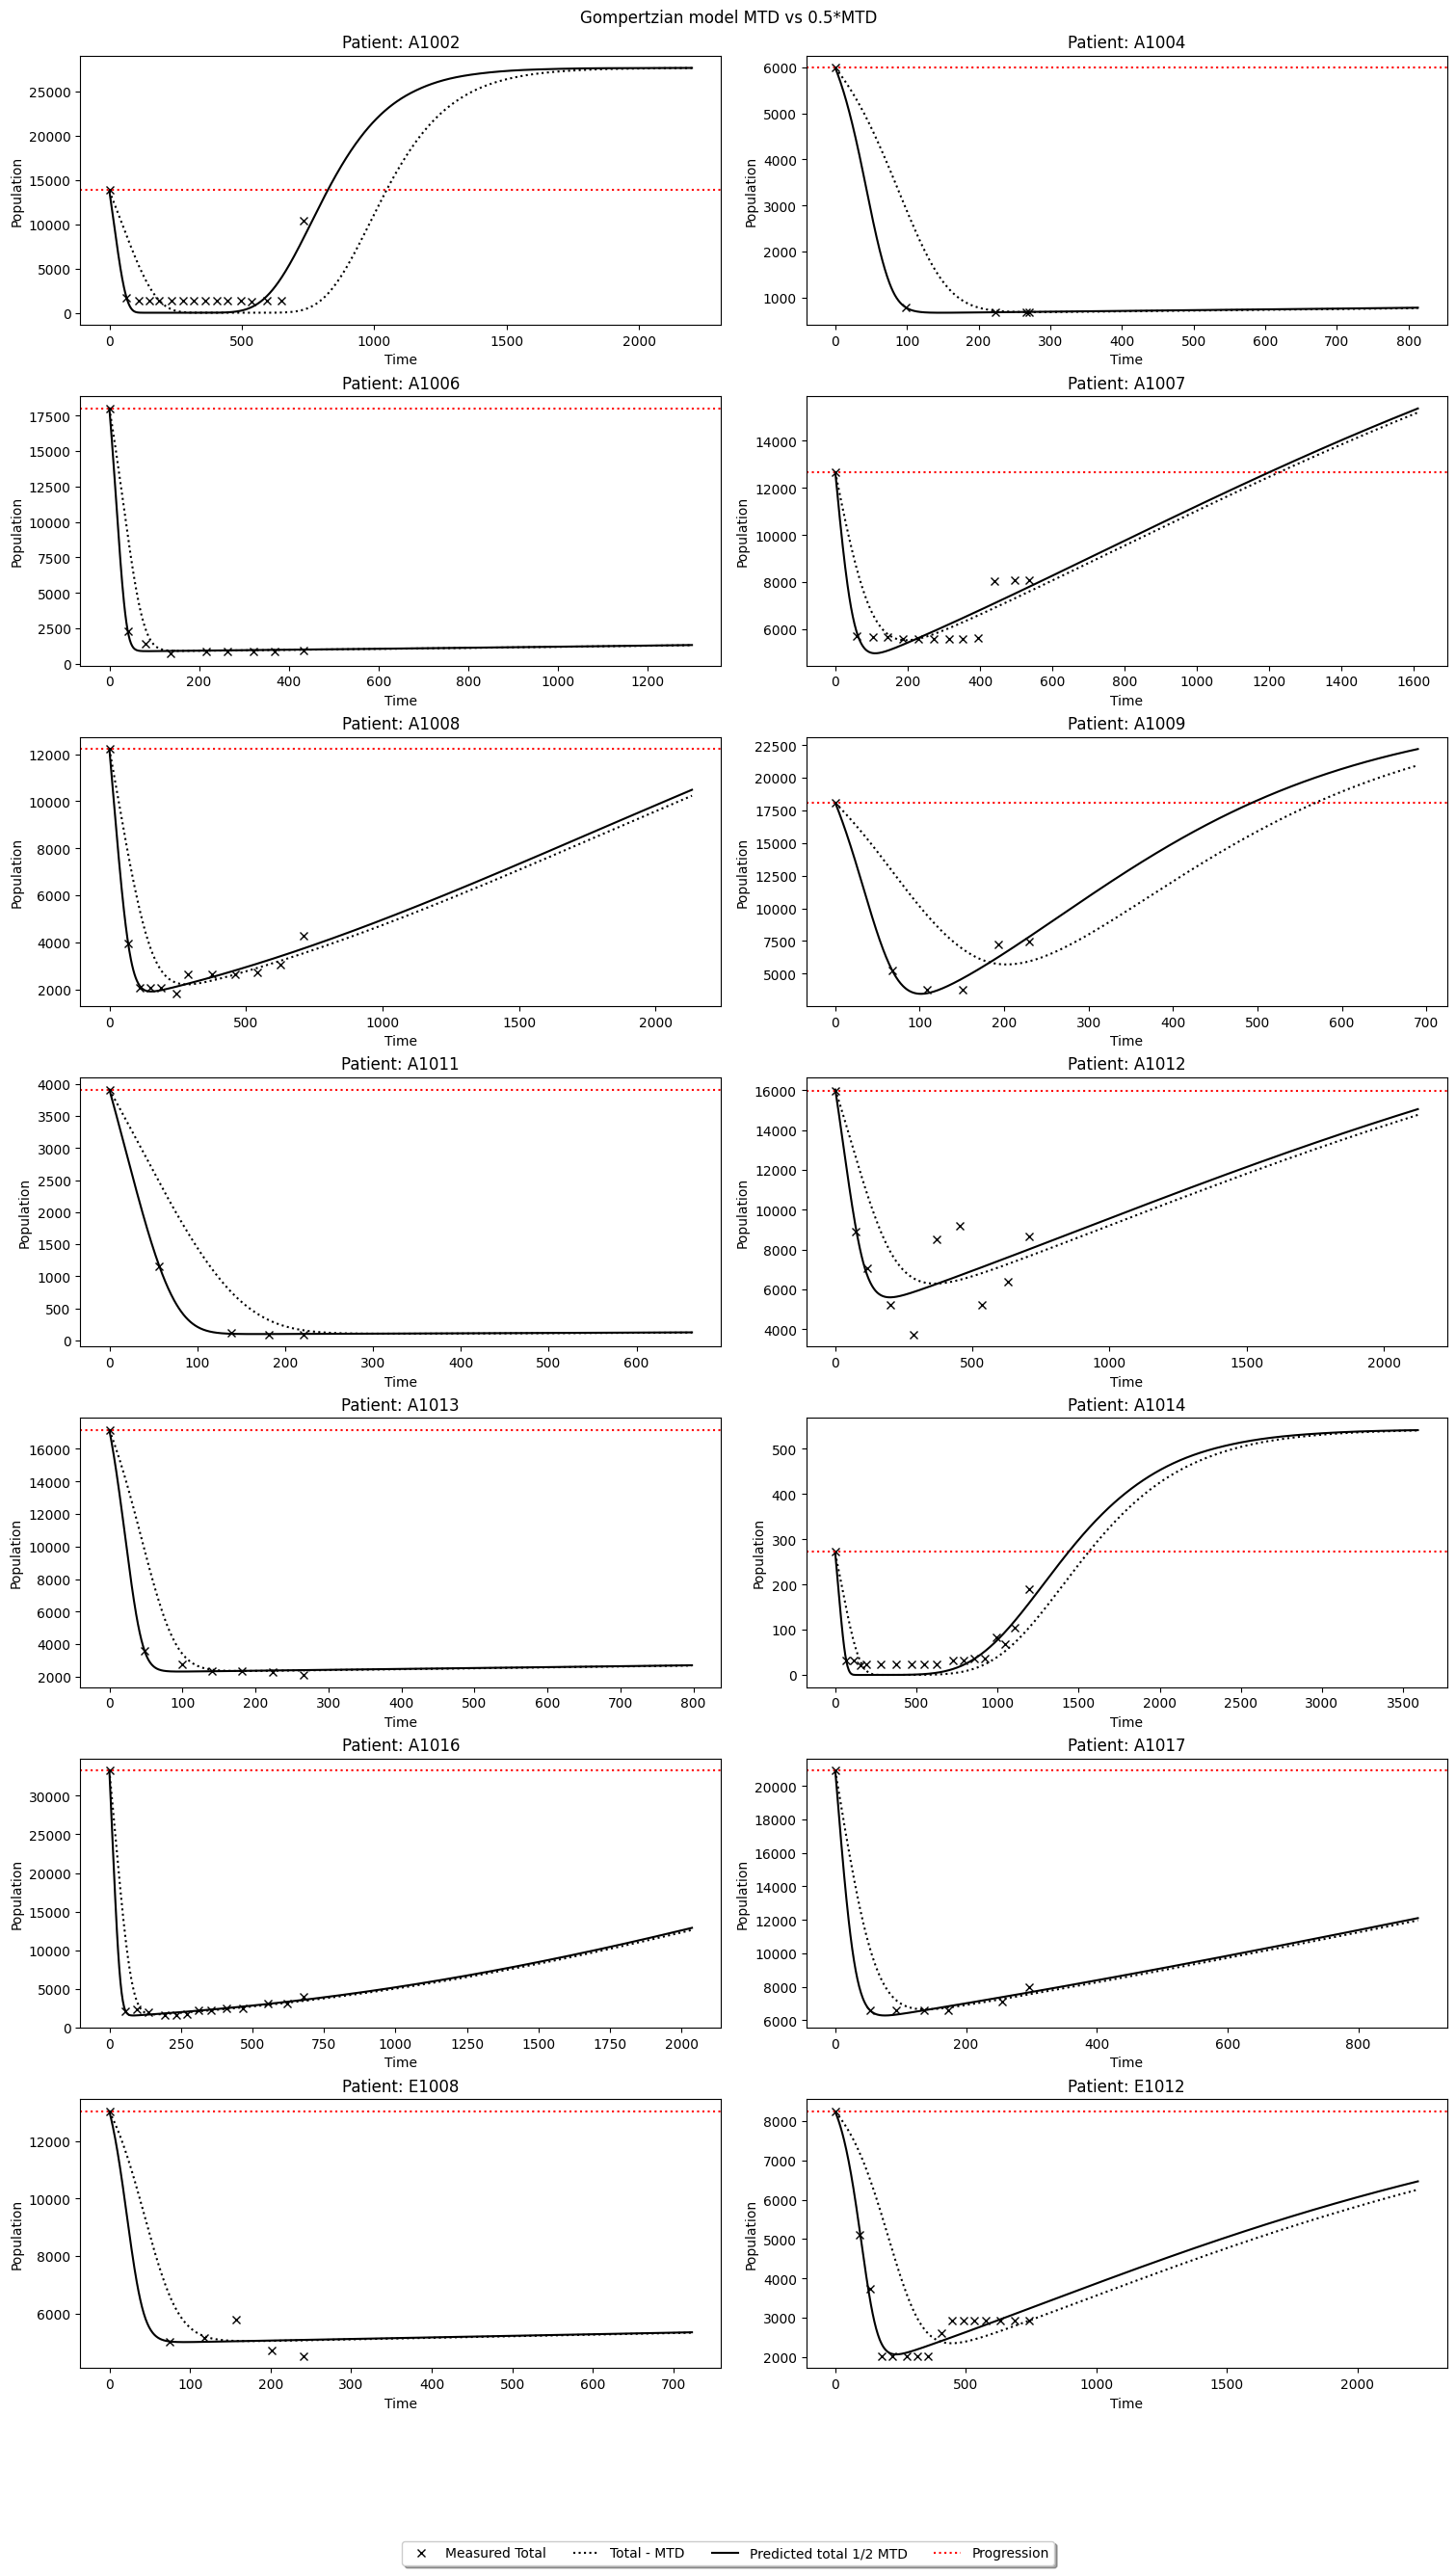

In [ ]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed

for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

n = len(unique_IDs)

ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 25), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    sim_time_factor = 3 # extend beyond the original data
    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

    ### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations_half, dense_output=True, 
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    ax.plot(days, data, 'kx', label='Measured Total') 
    ax.axhline(y=data[0], color='r', linestyle=':') ### line to show progression

    # plot with full medication
    #ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive MTD') # plot logistic model
    #ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant MTD') 
    ax.plot(tspan, sum_pops, 'k-', label='Total MTD')

    # plot with half medication
   # ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    #ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   #Line2D([0], [0], color='b', linestyle=':',label='Sensitive MTD'),
                  # Line2D([0], [0], color='r',linestyle=':', label='Resistant MTD'),
                   Line2D([0], [0], color='k', linestyle=':',label='Total - MTD'),

                  # Line2D([0], [0], color='b',  label='Predicted sensitive 1/2 MTD'),
                  # Line2D([0], [0], color='r',  label='Predicted resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', label='Predicted total 1/2 MTD'),
                   Line2D([[0]],[0], color='r',linestyle=":",label="Progression")]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model MTD vs 0.5*MTD')  
plt.show()

##### grid search for parameters (not needed now)

In [ ]:
#Grid search for parameters 


# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    
    log_arg = kmax/(Spop + Rpop + epsilon)

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop

        # Normalize the data to prevent overflow error
        data_mean = np.mean(data)
        data_std = np.std(data)
        normalized_data = (data - data_mean) / data_std

        sum_pops_mean = np.mean(sum_pops)
        sum_pops_std = np.std(sum_pops) + epsilon
        normalized_sum_pops = (sum_pops - sum_pops_mean) / sum_pops_std

        sumsq_error = np.sum((normalized_sum_pops - normalized_data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error

### Gompertzian model
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# list of lists for possible initial parameters
init_params_list = [[2e-2,5e-2, 1e-1],                             # params list growth rate
                    [1.5*data[0], 2*data[0], 3*data[0]],      # params list K 
                    [1,2,5,10],                              # params list lambda
                    [0.5*data[0], 0.75*data[0], data[0]],   # initial params list Spop
                    ]

# initial parameters Rpop - defined relative to Spop
# init_params_list.append([data[0] - spop for spop in init_params_list[3]])

# Generate all combinations of initial parameters
init_params_combinations = list(product(*init_params_list))
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days), "starting population:", data[0],"params = r,K,lamda,Spop, Rpop" )

    for init_params in init_params_combinations:
        init_params_with_rpop = init_params + ((data[0]-init_params[3]+1e-9,))

        print(f"Initial parameters: {init_params_with_rpop}")
        bounds = [(1e-2 , np.inf),          #r
                  (1.1*data[0], np.inf),   #K
                  (0, np.inf),              #lamda
                  (1e-9, data[0]),          # Spop_0
                  (1e-9, data[0])]              # Rpop_0
        opt_result = minimize(cost_func_gompertizian, init_params_with_rpop, args=(days, data), bounds = bounds, method="nelder-mead")
        # Store the optimized parameters and the cost function value in the dictionary
        # Use a tuple (id, tuple(init_params_with_rpop)) as the key to uniquely identify each optimization result
        master_dictionary[(id, tuple(init_params_with_rpop))] = opt_result.x.tolist() + [opt_result.fun]
    
